
# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
# Импортируем базовые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

# графики
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
pip install missingno

  Using cached missingno-0.5.2-py3-none-any.whl (8.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import missingno as msno

### Откройте файл с данными и изучите общую информацию. 

In [4]:
# Зададим формат отображения вещественных чисел в Pandas
pd.set_option('display.float_format', '{:,.2f}'.format)

# Сброс ограничений на число столбцов
#pd.set_option('display.max_columns', None)

# Сброс ограничений на число строк
#pd.set_option('display.max_rows', None)

# Сброс ограничений на количество символов в записи
#pd.set_option('display.max_colwidth', None)

# Не показываем предупреждения
# warnings.filterwarnings('ignore')

In [5]:
# Считываем датасет
data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00


In [6]:
# Выводим количество пропущенных значений (NaN или None) для каждого столбца 
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

<Axes: >

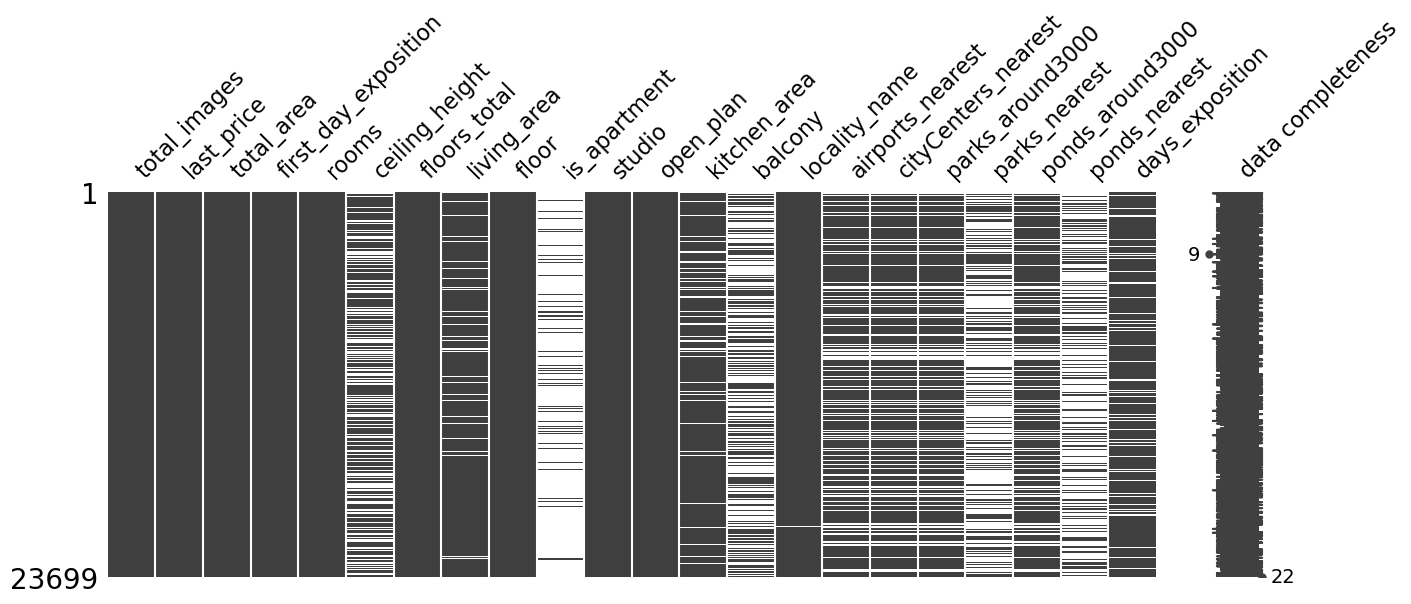

In [7]:
# Для визуальной оценки пропусков выведем матрицу пропущенных значений 
msno.matrix(data, labels=True, figsize=(15,5))

<Axes: >

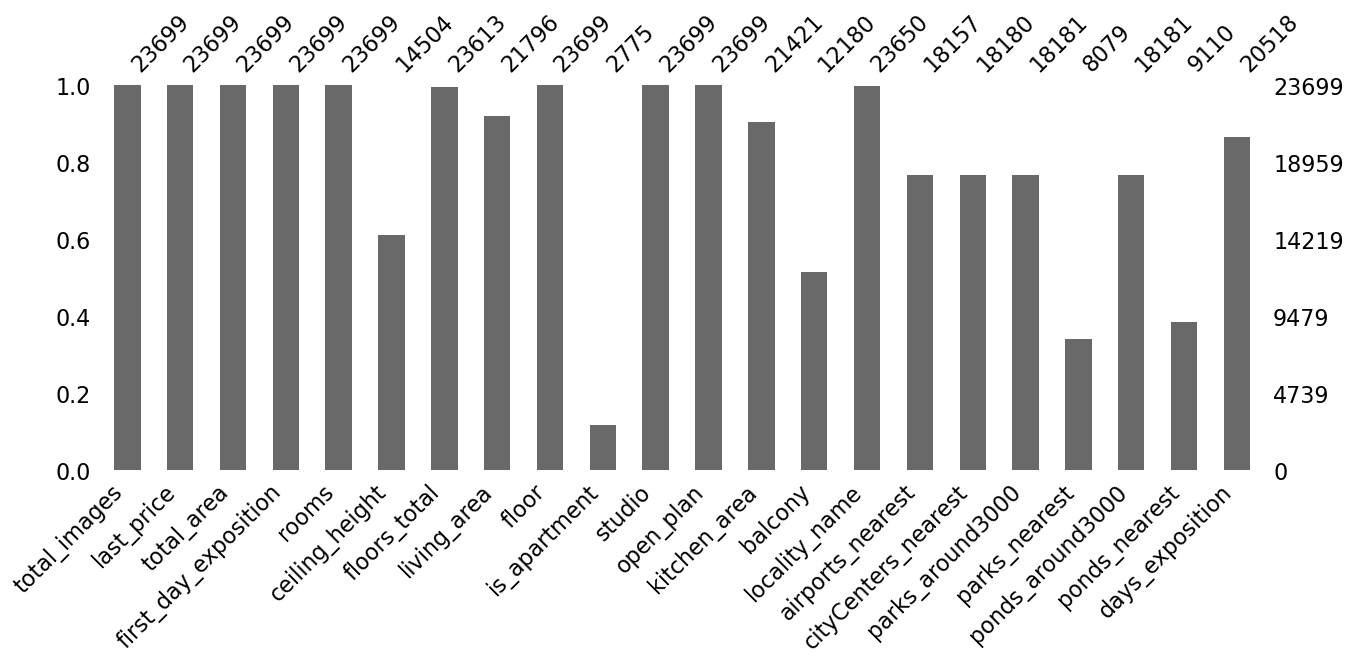

In [8]:
# Визуализация пропусков на стобчатой диаграмме, на которой указан % и абсолютное количество заполненных значений
msno.bar(data, figsize=(15,5))

<Axes: >

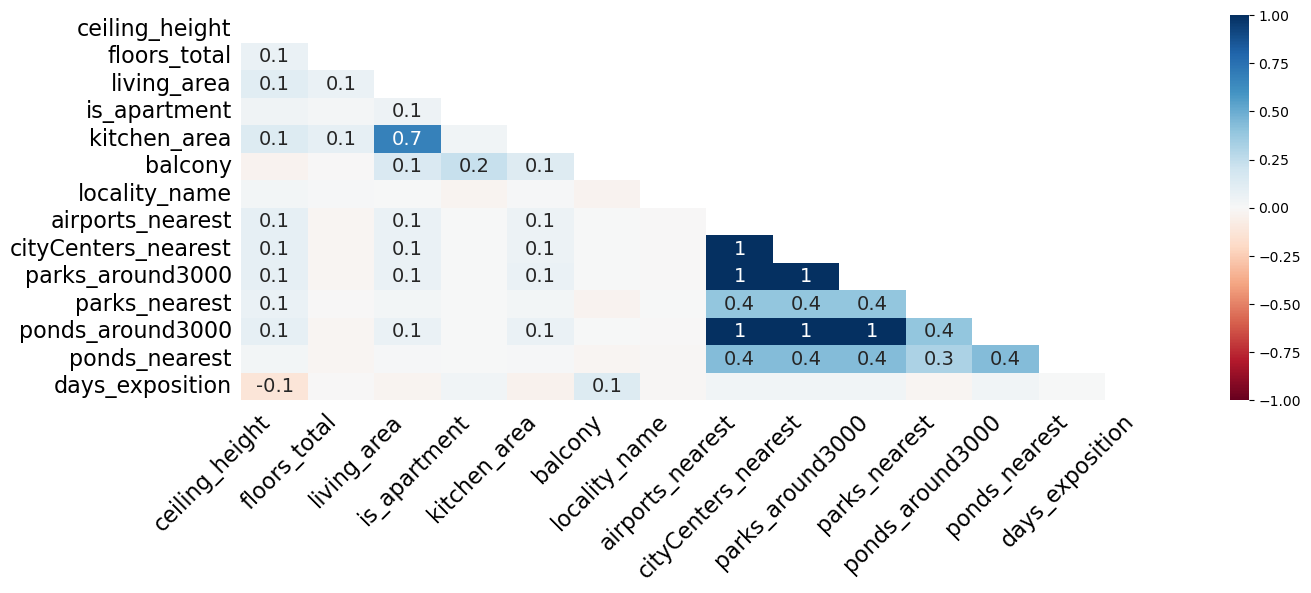

In [9]:
# Тепловая карта для визуализации корреляции пропущенных значений
msno.heatmap(data, figsize=(15,5))

Матрица корреляции пропущенных значений показывает меру взаимосвязи (наличие или отсутствие) между двумя величинами.  
Чем ближе значение корреляции к единице, тем синхроннее движутся анализируемые показатели.  
Отрицательная корреляция означает обратную взаимосвязь: рост одной величины приводит к падению другой.  


In [10]:
# Выводим сводную информацию о таблице (количество и названия столбцов, ненулевые значения, тип данных)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [11]:
# Выводим основные статистические характеристики данных
data.describe().astype('int')

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699,23699,23699,23699,14504,23613,21796,23699,21421,12180,18157,18180,18181,8079,18181,9110,20518
mean,9,6541548,60,2,2,10,34,5,10,1,28793,14191,0,490,0,517,180
std,5,10887013,35,1,1,6,22,4,5,1,12630,8608,0,342,0,277,219
min,0,12190,12,0,1,1,2,1,1,0,0,181,0,1,0,13,1
25%,6,3400000,40,1,2,5,18,2,7,0,18585,9238,0,288,0,294,45
50%,9,4650000,52,2,2,9,30,4,9,1,26726,13098,0,455,1,502,95
75%,14,6800000,69,3,2,16,42,8,12,2,37273,16293,1,612,1,729,232
max,50,763000000,900,19,100,60,409,33,112,5,84869,65968,3,3190,3,1344,1580


**Промежуточный вывод по итогам знакомства с данными:**  
- В некоторых солбцах датасета имеется много пропущенных значений.  
Однако столбцы, представляющие наибольшую ценность для исследования, заполнены достаточно полно: last_price, total_area,   
rooms, floor, locality_name, days_exposition (пропуски в days_exposition означают, что квартира ещё продается).  
По тепловой карте видно, что для многих столбцов корреляция пропусков близка к нулю, т.е. пропуски одного признака не влияют на пропуски другого.  

- В датасете имеется несколько столбцов с некорректным типом данных.

- При выводе основных статистических характеристик в глаза бросаются несколько сомнительных значений (возможно, это выбросы).

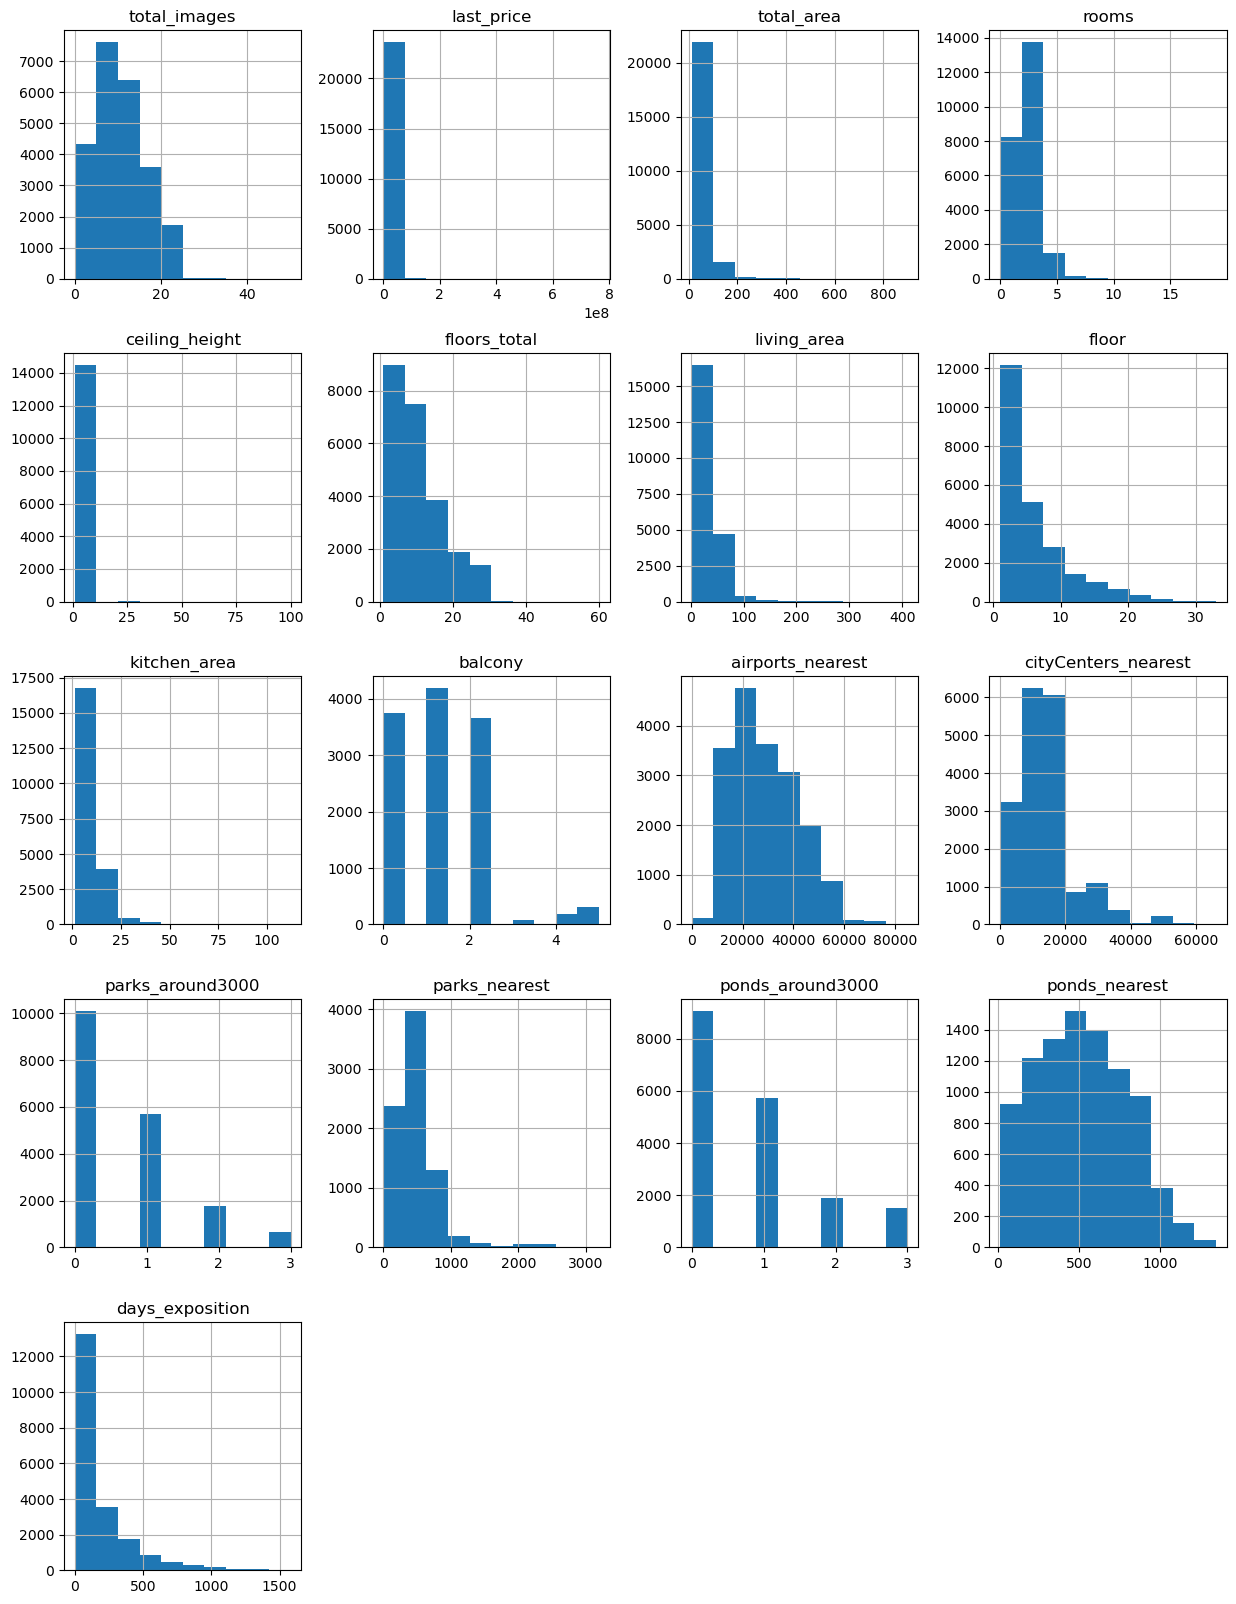

In [12]:
# Строим гистограммы для всех числовых столбцов
numeric_col = data.select_dtypes(include=np.number).columns.tolist()
data[numeric_col].hist(figsize=(15, 20)); 

### Предобработка данных

#### Подсчитаем число явных дубликатов

In [13]:
data.duplicated().sum()

0

Явные дубликаты не обнаружены


#### Предобработка столбца last_price

In [14]:
# Заменим тип на int 
data['last_price'] = data['last_price'].astype('int')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,3350000,40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,5196000,56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,64900000,159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,10000000,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00


In [15]:
# Выведем основные характеристики столбца
data['last_price'].describe()

count        23,699.00
mean      6,541,548.77
std      10,887,013.27
min          12,190.00
25%       3,400,000.00
50%       4,650,000.00
75%       6,800,000.00
max     763,000,000.00
Name: last_price, dtype: float64

Min цена 12 190 руб. подозрительно мала

In [16]:
# Выведем срез для просмотра
data.query('last_price < 300000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190,109.00,2019-03-20T00:00:00,2,2.75,25.00,32.00,25,NaN,...,40.50,NaN,Санкт-Петербург,"36,421.00","9,176.00",1.00,805.00,0.00,NaN,8.00


Цена квартиры в Санкт-Петербурге площадью 109 кв.м имеет аномальное значение 12190 руб.
Судя по всему имелось в виду 12190 млн.руб.

In [17]:
# Заменяем аномальное значение
data['last_price'] = data['last_price'].replace(12190, 12190000)

# Посмотрим на минимальную цену после удаления аномалии
data['last_price'].min()

430000

Теперь минимальная цена недвижимости выглядит адекватно.

In [18]:
# Проверим пропущенные значения
data['last_price'].isna().sum()

0

Пропущенных значений в столбце last_price нет.   

Данные выглядят правдоподобно, предобработка столбца last_price завершена.

#### Предобработка столбца total_area

In [19]:
# Выведем основные характеристики столбца
data['total_area'].describe()

count   23,699.00
mean        60.35
std         35.65
min         12.00
25%         40.00
50%         52.00
75%         69.90
max        900.00
Name: total_area, dtype: float64

In [20]:
# Проверим пропущенные значения
data['total_area'].isna().sum()

0

Пропущенных значений в столбце total_area нет, данные выглядят правдоподобно и не требуют вмешательства.

#### Предобработка столбца first_day_exposition

In [21]:
# Проверим пропущенные значения
data['first_day_exposition'].isna().sum()

0

In [22]:
# Изменим тип данных на datetime, округлив до дня
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT').dt.round('1D')

Теперь данные в столбце first_day_exposition выглядят хорошо.

#### Предобработка столбца rooms

In [23]:
# Выведем основные характеристики столбца
data['rooms'].describe()

count   23,699.00
mean         2.07
std          1.08
min          0.00
25%          1.00
50%          2.00
75%          3.00
max         19.00
Name: rooms, dtype: float64

In [24]:
# Посмотрим на срез с числом комнат 0
#data.query('rooms == 0')

In [25]:
# Проверим пропущенные значения
data['rooms'].isna().sum()

0

Пропущенных значений нет.
Немного смущают квартиры с числом комнат 0, но возможно это квартиры с открытой планировкой, студии или что-то подобное.
Поэтому оставляем столбец rooms как есть.

#### Предобработка столбца ceiling_height

In [26]:
# Выведем основные характеристики столбца
data['ceiling_height'].describe()

count   14,504.00
mean         2.77
std          1.26
min          1.00
25%          2.52
50%          2.65
75%          2.80
max        100.00
Name: ceiling_height, dtype: float64

In [27]:
# Посмотрим на уникальные значения
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

In [28]:
# Выводим срез очевидных аномальных значений высоты потолков (с учетом "второго света" в загородных домах)
#data.query('ceiling_height < 2 or ceiling_height >=6')

In [29]:
# Предполагаем, что аномальные значения высоты потолков связаны с технической ошибкой - пропущена точка-разделитель
# Производим замену в диапазоне высоты полотков 20-60 метров, оставшиеся аномальные значения оставляем как есть

data.loc[(data['ceiling_height'] >= 20) & (data['ceiling_height'] < 60), 'ceiling_height'] \
= data.loc[(data['ceiling_height'] >= 20) & (data['ceiling_height'] < 60), 'ceiling_height'] / 10

In [30]:
# Проверяем результат замены
#data.query('ceiling_height < 2 or ceiling_height >=6')

In [31]:
# Проверим пропущенные значения
data['ceiling_height'].isna().sum()

9195

In [32]:
# Заменим пропуски на медианное значение
median_ceiling_height = data['ceiling_height'].median()
data['ceiling_height'] = data['ceiling_height'].fillna(median_ceiling_height)

In [33]:
# Проверим результат замены пропусков
data['ceiling_height'].isna().sum()

0

В столбце ceiling_height осталось 6 строк с аномальными значениями, которые нельзя исправить.  


Однако удалять эти строки мы не будем, чтобы не лишится полезной информации из других столбцов. 

#### Предобработка столбца floors_total

In [34]:
# Выведем основные характеристики столбца
data['floors_total'].describe()

count   23,613.00
mean        10.67
std          6.60
min          1.00
25%          5.00
50%          9.00
75%         16.00
max         60.00
Name: floors_total, dtype: float64

In [35]:
# Проверим пропущенные значения
data['floors_total'].isna().sum()

86

In [36]:
# Изменяем тип данных на int, т.к. число этажей в доме не может быть дробным числом
data['floors_total'].astype(pd.Int64Dtype())

0        16
1        11
2         5
3        14
4        14
         ..
23694     5
23695     5
23696     3
23697    17
23698     5
Name: floors_total, Length: 23699, dtype: Int64

В столбце floors_total имеется 86 пропущенных значений.  
Заменить пропуски на каие-либо значения не получится.  
Удалять эти строки нельзя, чтобы не потерять полезную информацию из других столбцов.   

#### Предобработка столбца living_area

In [37]:
# Выведем основные характеристики столбца
data['living_area'].describe()

count   21,796.00
mean        34.46
std         22.03
min          2.00
25%         18.60
50%         30.00
75%         42.30
max        409.70
Name: living_area, dtype: float64

In [38]:
# Проверим пропущенные значения
data['living_area'].isna().sum()

1903

В столбце living_area имеется много пропущенных значений.  
Оставляем столбец без изменений - удалять или заменять пропущенные значения не будем, чтобы не навредить лишней обработкой.

#### Предобработка столбца floor

In [39]:
# Выведем основные характеристики столбца
data['floor'].describe()

count   23,699.00
mean         5.89
std          4.89
min          1.00
25%          2.00
50%          4.00
75%          8.00
max         33.00
Name: floor, dtype: float64

In [40]:
# Проверим пропущенные значения
data['floor'].isna().sum()

0

Пропущенных значений в столбце floor нет, данные выглядят правдоподобно.

#### Предобработка столбца is_apartment

In [41]:
# Посмотрим на уникальные значения
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

In [42]:
# Посчитаем число каждого уникального значения
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

In [43]:
# Проверим пропущенные значения
data['is_apartment'].isna().sum()

20924

Предполагаем, что такое большое количество пропусков связано с тем, что объекты недвижимости не являеются аппартаментами.

In [44]:
# Заменяем пропуски на False
data['is_apartment'] = data['is_apartment'].fillna(False)

In [45]:
# Изменим тип данных object на bool
data['is_apartment'] = data['is_apartment'].astype(bool)

In [46]:
# Проверим результат замены 
data['is_apartment'].value_counts()

False    23649
True        50
Name: is_apartment, dtype: int64

Пропущенных значений в столбце is_apartment нет, данные выглядят хорошо.

#### Предобработка столбца kitchen_area

In [47]:
# Выведем основные характеристики столбца
data['kitchen_area'].describe()

count   21,421.00
mean        10.57
std          5.91
min          1.30
25%          7.00
50%          9.10
75%         12.00
max        112.00
Name: kitchen_area, dtype: float64

In [48]:
# Проверим пропущенные значения
data['kitchen_area'].isna().sum()

2278

В столбце kitchen_area имеется много пропущенных и не очень правдоподобных значений (например, min =1,3 метра).  
Оставляем столбец без изменений - удалять/заменять ничего не будем, чтобы не исказить данные и не навредить лишней обработкой.

#### Предобработка столбца balcony

In [49]:
# Выведем основные характеристики столбца
data['balcony'].describe()

count   12,180.00
mean         1.15
std          1.07
min          0.00
25%          0.00
50%          1.00
75%          2.00
max          5.00
Name: balcony, dtype: float64

In [50]:
# Проверим пропущенные значения
data['balcony'].isna().sum()

11519

Предполагаем, что пропуски подразумевают отсутствие балкона, поэтому заменяем все пропуски на ноль.

In [51]:
# Одновременно заменяем тип данных на int, т.к. число балконов не может быть дробным числом
data['balcony'] = data['balcony'].fillna(0).astype(int)

In [52]:
# Проверим результат замены 
data['balcony'].isna().sum()

0

Пропущенных значений в столбце balcony нет, данные выглядят хорошо.

#### Предобработка столбца locality_name

In [53]:
# Выведем основные характеристики столбца
data['locality_name'].describe()

count               23650
unique                364
top       Санкт-Петербург
freq                15721
Name: locality_name, dtype: object

In [54]:
# Проверим пропущенные значения
data['locality_name'].isna().sum()

49

In [55]:
# Заменяем пропуски на 'адрес не указан'
data['locality_name'] = data['locality_name'].fillna('адрес не указан')

In [56]:
# Проверим результат замены 
data['locality_name'].isna().sum()

0

In [57]:
# Посмотрим на уникальные названия населенных пунктов
# data['locality_name'].unique()

In [58]:
# Выведем число уникальных значений
#data['locality_name'].value_counts()

Общее число уникальных населенных пунктов равно 365.

In [59]:
# Преобразуем все названия к нижнему регистру
data['locality_name'] = data['locality_name'].str.lower()

In [60]:
# Заменяем неявные дубликаты
data['locality_name'] = data['locality_name'] \
.replace(['посёлок', 'городской пос[её]лок', 'пос[её]лок городского типа', 'коттеджный пос[её]лок'], 'поселок', regex=True)

data['locality_name'] = data['locality_name'] \
.replace('садоводческое некоммерческое товарищество', 'садовое товарищество', regex=True)

In [61]:
# Выведем число уникальных значений после преобразования и замены
# data['locality_name'].value_counts()

Общее число уникальных населенных пунктов уменьшилось с 365 до 322.

После замены пропусков и неявных дубликатов данные стали выглядеть лучше.  

#### Предобработка столбца airports_nearest

In [62]:
# Выведем основные характеристики столбца
data['airports_nearest'].describe()

count   18,157.00
mean    28,793.67
std     12,630.88
min          0.00
25%     18,585.00
50%     26,726.00
75%     37,273.00
max     84,869.00
Name: airports_nearest, dtype: float64

In [63]:
# Проверим пропущенные значения
data['airports_nearest'].isna().sum()

5542

Предполагаем, что пропуски связаны с отсутствием аэропорта поблизости.  
Заменить пропуски не представляется возможным, т.к. расстояние до аэропорта может иметь огромный диапазон значений.  
Во-избежание искажения результатов дальнейшего анализа мы не будем трогать эти пропуски.

#### Предобработка столбца parks_around3000

In [64]:
# Выведем основные характеристики столбца
data['parks_around3000'].describe()

count   18,181.00
mean         0.61
std          0.80
min          0.00
25%          0.00
50%          0.00
75%          1.00
max          3.00
Name: parks_around3000, dtype: float64

In [65]:
# Проверим пропущенные значения
data['parks_around3000'].isna().sum()

5518

Предполагаем, что пропуски связаны с отсутствием парков в радиусе 3 км.

In [66]:
# Заменяем пропуски на ноль, изменяем тип данных
data['parks_around3000'] = data['parks_around3000'].fillna(0).astype(int)

In [67]:
# Проверяем результат замены
data['parks_around3000'].isna().sum()

0

Пропущенных значений в столбце parks_around3000 нет, данные выглядят хорошо.

##### Предобработка столбца parks_nearest

In [68]:
# Выведем основные характеристики столбца
data['parks_nearest'].describe()

count   8,079.00
mean      490.80
std       342.32
min         1.00
25%       288.00
50%       455.00
75%       612.00
max     3,190.00
Name: parks_nearest, dtype: float64

In [69]:
# Проверим пропущенные значения
data['parks_nearest'].isna().sum()

15620

Предполагаем, что пропуски связаны с отсутствием парков поблизости.  
Заменить пропуски не представляется возможным, т.к. расстояние до ближайшего парка непредсказуемо и может иметь огромный диапазон значений.    
Во-избежание искажения результатов дальнейшего анализа мы не будем трогать эти пропуски.  

##### Предобработка столбца ponds_around3000

In [70]:
# Выведем основные характеристики столбца
data['ponds_around3000'].describe()

count   18,181.00
mean         0.77
std          0.94
min          0.00
25%          0.00
50%          1.00
75%          1.00
max          3.00
Name: ponds_around3000, dtype: float64

In [71]:
# Проверим пропущенные значения
data['ponds_around3000'].isna().sum()

5518

Предполагаем, что пропуски связаны с отсутствием водоемов в радиусе 3 км.

In [72]:
# Заменяем пропуски на ноль, изменяем тип данных
data['ponds_around3000'] = data['ponds_around3000'].fillna(0).astype(int)

In [73]:
# Проверячем результат замены
data['ponds_around3000'].isna().sum()

0

Пропущенных значений в столбце ponds_around3000 нет, данные выглядят хорошо.

##### Предобработка столбца ponds_nearest

In [74]:
# Выведем основные характеристики столбца
data['ponds_nearest'].describe()

count   9,110.00
mean      517.98
std       277.72
min        13.00
25%       294.00
50%       502.00
75%       729.00
max     1,344.00
Name: ponds_nearest, dtype: float64

In [75]:
# Проверим пропущенные значения
data['ponds_nearest'].isna().sum()

14589

Предполагаем, что пропуски связаны с отсутствием водоемов поблизости.  
Заменить пропуски не представляется возможным, т.к. расстояние до ближайшего водоема непредсказуемо и может иметь огромный диапазон значений.    
Во-избежание искажения результатов дальнейшего анализа мы не будем трогать эти пропуски.  

##### Предобработка столбца cityCenters_nearest

In [76]:
# Выведем основные характеристики столбца
data['cityCenters_nearest'].describe()

count   18,180.00
mean    14,191.28
std      8,608.39
min        181.00
25%      9,238.00
50%     13,098.50
75%     16,293.00
max     65,968.00
Name: cityCenters_nearest, dtype: float64

In [77]:
# Проверим пропущенные значения
data['cityCenters_nearest'].isna().sum()

5519

Заменить пропуски не представляется возможным, т.к. расстояние до центра непредсказуемо и может иметь огромный диапазон значений.    
Во-избежание искажения результатов дальнейшего анализа мы не будем трогать эти пропуски. 

#### Предобработка столбца days_exposition

In [78]:
# Выведем основные характеристики столбца
data['days_exposition'].describe()

count   20,518.00
mean       180.89
std        219.73
min          1.00
25%         45.00
50%         95.00
75%        232.00
max      1,580.00
Name: days_exposition, dtype: float64

In [79]:
# Проверим пропущенные значения
data['days_exposition'].isna().sum()

3181

В столбце days_exposition имеется мнгого пропущенных значений.  
Пропуски означают, что объявление ещё не снято (квартира ёще продается).  
Заменить пропуски на каие-либо значения нельзя - иначе сильно исказим данные.  
Удалить пропуски тоже нельзя - иначе потеряем полезную информацию из других столбцов.  
Тип данных в этом столбце указан не корректно, т.к. количесвто дней не может быть дробным числом.   
Однако мы не можем изменить его на int в связи с наличием пропущенных значений.     
Оставляем столбец без изменений, учитывая, что тип данных float64 тоже подходит для наших вычислений.

**ПРОМЕЖУТОЧНЫЙ ВЫВОД по итогам предобработки данных:**   

 - Явные дубликаты в датасете не обнаружены  
 
**Результат предобработки данных по столбцам:**  
 
 0   total_images          - предобработка не требуется  
 
 1   last_price            - пропусков нет, тип данных заменили, исправили аномальное значение  
 
 2   total_area            - предобработка не требуется   
 
 3   first_day_exposition  - пропусков нет, тип данных заменили   
 
 4   rooms                 - предобработка не требуется   
 
 5   ceiling_height        - заполнили пропуски, тип данных корректен, исправили некоторые аномальные значения,   
                             но в данных остались строки с выбросами, которые нельзя исправить  
 
 6   floors_total          - тип данных заменили, но в данных остались пропущенные значения, которые нельзя заменить  

 7   living_area           - в данных остались пропущенные значения, которые нельзя заменить    

 8   floor                 - предобработка не требуется  
 
 9   is_apartment          - заполнили пропуски, изменили тип данных   
                           
 10  studio                - предобработка не требуется   
 
 11  open_plan             - предобработка не требуется    
 
 12  kitchen_area          - в данных остались пропущенные значения, которые нельзя заменить  
                           
 13  balcony               - заполнили пропуски, изменили тип данных   
                           
 14  locality_name         - заполнили пропуски, тип данных корректен, заменили неявные дубликаты  
                           
 15  airports_nearest      - в данных остались пропущенные значения, которые нельзя заменить   
                           
 16  cityCenters_nearest   - в данных остались пропущенные значения, которые нельзя заменить   
 
 17  parks_around3000      - заполнили пропуски, изменили тип данных  
                           
 18  parks_nearest         - в данных остались пропущенные значения, которые нельзя заменить   
 
 19  ponds_around3000      - заполнили пропуски, изменили тип данных
 
 20  ponds_nearest         - в данных остались пропущенные значения, которые нельзя заменить   
                           
 21  days_exposition       - в данных остались пропущенные значения, которые нельзя заменить, тип данных не корректен, но изменить нельзя


### Посчитайте и добавьте в таблицу новые столбцы

In [80]:
# Создадим столбец со стоимостью одного кв. метра
data['price_per_meter'] = round((data['last_price'] / data['total_area']), 0)
#data.head()

In [81]:
# Создадим столбец с днем недели публикации объявления
data['weekday_first_day_exposition'] = data['first_day_exposition'].dt.weekday
#data.head()

In [82]:
# Посмотрим на количество обявлений с разбивкой по дням недели
data['weekday_first_day_exposition'].value_counts()

3    4295
1    4183
4    4000
2    3974
0    3612
5    1936
6    1699
Name: weekday_first_day_exposition, dtype: int64

In [83]:
# Создадим столбец с месяцем публикации объявления
data['month_first_day_exposition'] = data['first_day_exposition'].dt.month
#data.head()

In [84]:
# Посмотрим на количество обявлений с разбивкой по месяцам
data['month_first_day_exposition'].value_counts()

2     2640
3     2587
4     2379
11    2371
10    2127
9     1981
6     1760
8     1744
7     1695
12    1641
1     1500
5     1274
Name: month_first_day_exposition, dtype: int64

In [85]:
# Создадим столбец с годом публикации объявления
data['year_first_day_exposition'] = data['first_day_exposition'].dt.year
#data.head()

In [86]:
# Посмотрим на количество обявлений с разбивкой по годам
data['year_first_day_exposition'].value_counts()

2018    8519
2017    8190
2019    2879
2016    2783
2015    1191
2014     137
Name: year_first_day_exposition, dtype: int64

In [87]:
# Для создания столбца с типом этажа (первый, последний, другой) создаем функцию категоризации 

def floor_category(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
# Создаем новый столбец с категорированием по типу этажа 
data['floor_category'] = data.apply(floor_category, axis = 1)

# data.head()

In [88]:
# Создаем столбец расстояния до центра города (переводим из метров в км)

data['center_distance'] = round((data['cityCenters_nearest'] / 1000), 0)
#data['center_distance'].head()

### Проведите исследовательский анализ данных

#### Изучим некоторые параметры объектов недвижимости

##### Построим гистограмму для общей площади, опишем наблюдения 

In [89]:
#data['total_area'].hist(bins=30, figsize=(10,5))

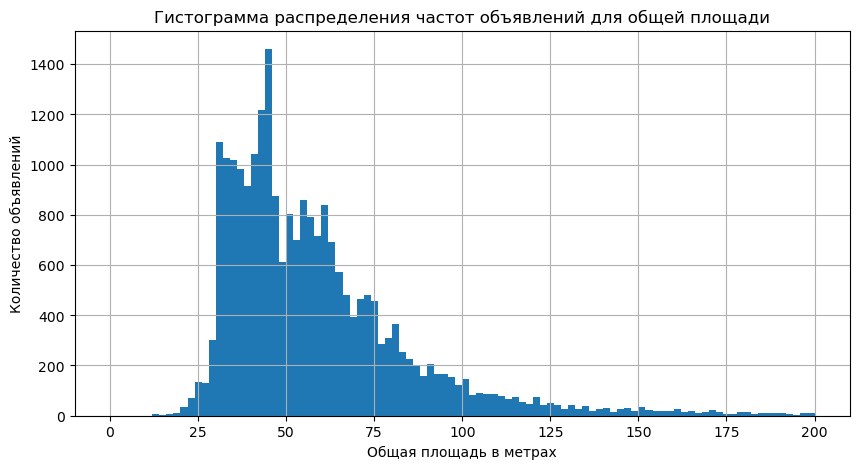

In [90]:
# Чтобы раcсмотреть особенности распределения значений в интервале их наибольшего скопления, 
# построим гистограмму в другом масштабе, указав диапазон значений от 0 до 200

data['total_area'].hist(bins=100, figsize=(10,5), range=(0,200))
plt.xlabel('Общая площадь в метрах')
plt.ylabel('Количество объявлений')
plt.title('Гистограмма распределения частот объявлений для общей площади')
plt.show()

На гистограммах видно, что разброс значений велик.  
Подавляющее большинство объектов недвижимости имеет общую площадь до 100 кв.м.  
Ярко выражен пик квартир общей площадью 40 кв.м.  
В объявляениях также встречается недвижимость, имеющая очень большую общую площадь (вплоть до 1000 кв.м), но таких объявлений очень мало.

##### Построим гистограмму для жилой площади, опишем наблюдения

In [91]:
#data['living_area'].hist(bins=30, figsize=(10,5))

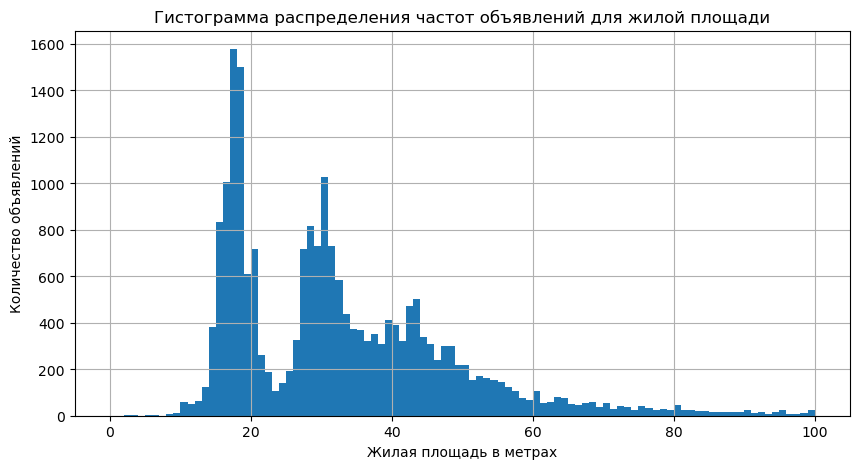

In [92]:
# Чтобы расcмотреть особенности распределения значений в интервале их наибольшего скопления, 
# построим гистограмму в другом масштабе, указав диапазон значений от 0 до 100

data['living_area'].hist(bins=100, figsize=(10,5), range=(0, 100))
plt.xlabel('Жилая площадь в метрах')
plt.ylabel('Количество объявлений')
plt.title('Гистограмма распределения частот объявлений для жилой площади')
plt.show()

На гистограммах видно, что разброс значений велик - в объявляениях встречается недвижимость с жилой площадью от 0 до 400 кв.м.  
Однако подавляющее большинство квартир имеет жилую площадь до 60 кв.м.   
Судя по трем пикам на гистограмме, самое распространенное значение жилой площади приходится на 17-18 кв.м, затем - на 30 кв.м, а потом на 45 кв. м.  


##### Построим гистограмму для площади кухни, опишем наблюдения

In [93]:
#data['kitchen_area'].hist(bins=30, figsize=(10,5))

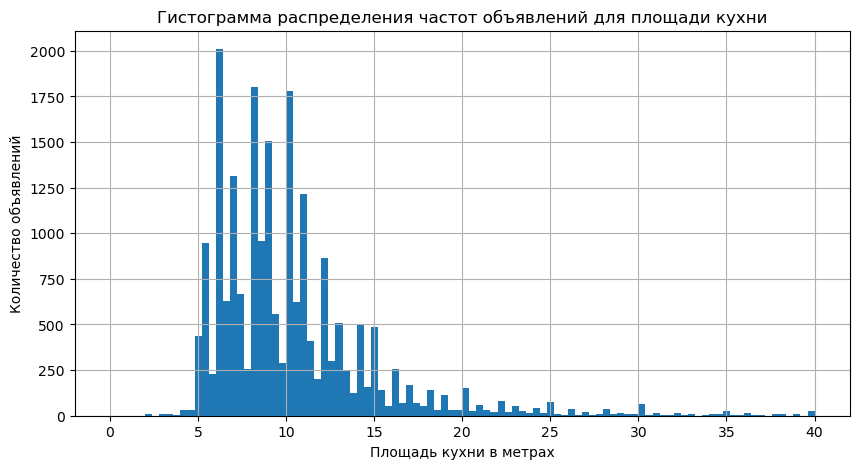

In [94]:
# Чтобы раcсмотреть особенности распределения значений в интервале их наибольшего скопления, 
# построим гистограмму в другом масштабе, указав диапазон значений от 0 до 40

data['kitchen_area'].hist(bins=100, figsize=(10,5), range=(0, 40))
plt.xlabel('Площадь кухни в метрах')
plt.ylabel('Количество объявлений')
plt.title('Гистограмма распределения частот объявлений для площади кухни')
plt.show()

На гистограммах видно, что разброс значений велик.  
Подавляющее большинство объектов недвижимости имеет площадь кухни до 13-15 кв.м, пик приходится на 6-10 кв.м.  
Однако в объявляениях также встречаются квартиры с площадью кухни свыше 100 кв.м, но таких объявлений очень мало.  

##### Построим гистограмму для цены объекта, опишем наблюдения

In [95]:
#data['last_price'].hist(bins=100, figsize=(15,5))

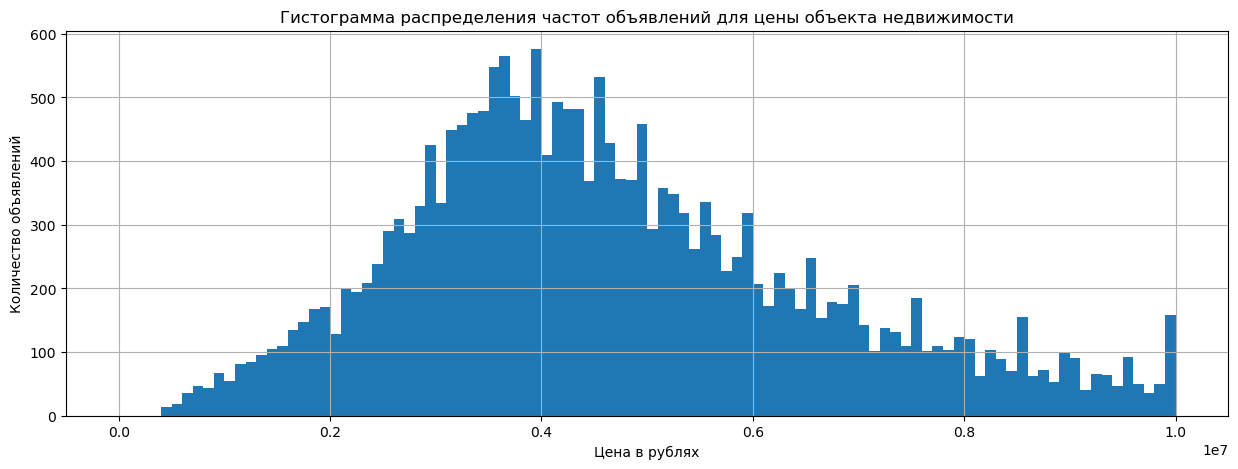

In [96]:
# Чтобы раcсмотреть особенности распределения значений в интервале их наибольшего скопления, 
# построим гистограмму в другом масштабе, указав диапазон значений от 0 до 10000000

data['last_price'].hist(bins=100, figsize=(15,5), range=(0, 10000000))
plt.xlabel('Цена в рублях')
plt.ylabel('Количество объявлений')
plt.title('Гистограмма распределения частот объявлений для цены объекта недвижимости')
plt.show()

На гистограммах видно, что разброс значений очень велик.  
Цена подавляющего большинства объектов недвижимости находится в интервале до 10 млн. рублей.  
Пик цен на квартиры приходится на интервао от 3 до 4,5 млн. руб.  
В объявляениях также встречается очень дорогая недвижимость - вплоть до 700 млн. рублей, но таких объявлений существенно меньше. 

##### Построим гистограмму для количества комнат, опишем наблюдения

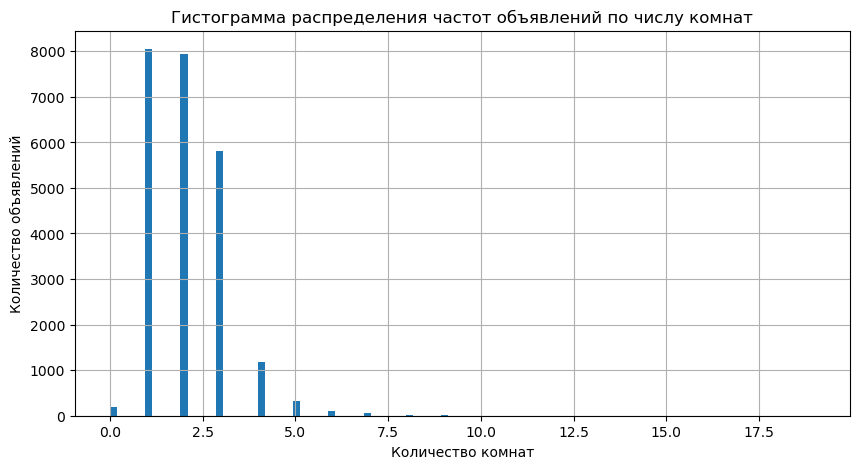

In [97]:
data['rooms'].hist(figsize=(10,5), bins=100)
plt.xlabel('Количество комнат')
plt.ylabel('Количество объявлений')
plt.title('Гистограмма распределения частот объявлений по числу комнат')
plt.show()

На гистограмме видно, что разброс количества комнат велик.  
В основном продаются однушки и двушки (их примерно поровну).  
Трёшек проедлагается примерно на 30% меньше, чем однушек и двушек.  
В объявляениях встречается элитная недвижимость с числом комнат свыше 17, но таких объявлений очень мало.

##### Построим гистограмму для высоты потолков, опишем наблюдения


In [98]:
#data['ceiling_height'].hist(bins=100, figsize=(10,5))

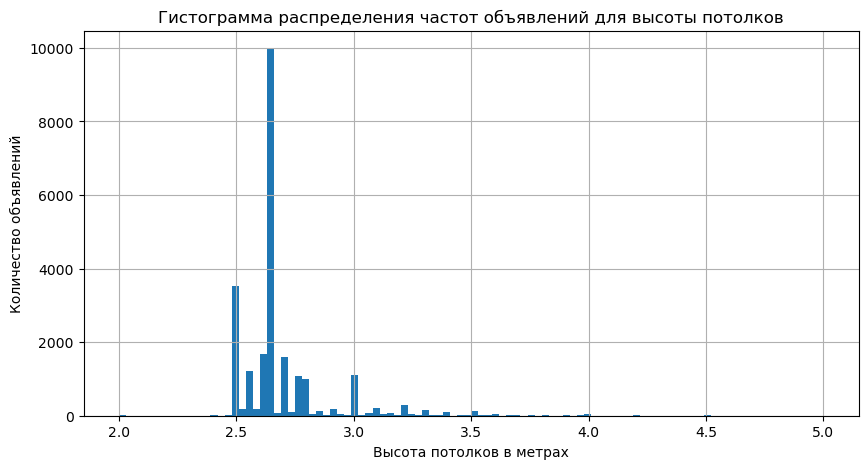

In [99]:
# Ввиду наличия в датасете аномальных значений, которые мы не заменияли и не удаляли,  
# для исследования закономерности распределения параметра, построим гистограмму без выбивающихся значений,
# ограничив высоту потолков 5 метрами.

data['ceiling_height'].hist(range = (2, 5), bins=100, figsize=(10,5))
plt.xlabel('Высота потолков в метрах')
plt.ylabel('Количество объявлений')
plt.title('Гистограмма распределения частот объявлений для высоты потолков')
plt.show()

В подавляющем большинстве высота потолков приходится на интервал от 2,5 до 3,0 метров.  
Самая распространенная высота потолка - ярко выраженный пик 2,7 метра. 

##### Построим гистограмму для этажа квартиры, опишем наблюдения

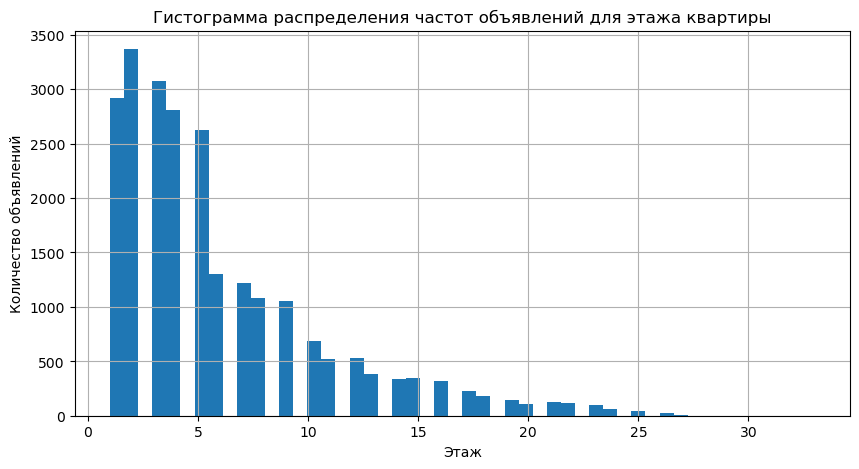

In [100]:
data['floor'].hist(bins=50, figsize=(10,5))
plt.xlabel('Этаж')
plt.ylabel('Количество объявлений')
plt.title('Гистограмма распределения частот объявлений для этажа квартиры')
plt.show()

Много продающихся квартир расположено до 9 этажа, причем большинство из них расположены с 1 по 5 этаж.
Очень мало предложений квартир, расположенных на высоких этажах (выше 20 этажа).  

##### Построим гистограмму для типа этажа квартиры, опишем наблюдения

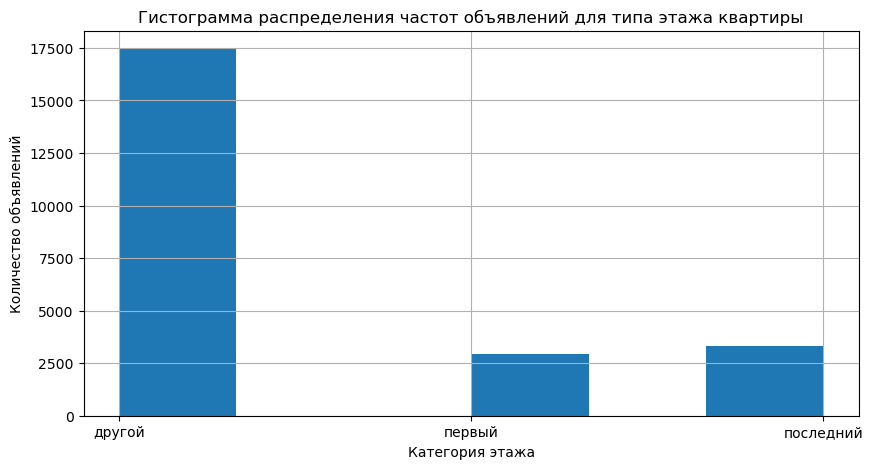

In [101]:
data['floor_category'].hist(bins=6, figsize=(10,5))
plt.xlabel('Категория этажа')
plt.ylabel('Количество объявлений')
plt.title('Гистограмма распределения частот объявлений для типа этажа квартиры')
plt.show()

Имеется три четко выраженных категории этажей: первый, последний и другой.   
"Других" этажей приблизительно в 6 раз больше, чем крайних.  
Первых и последних этажей примерно поровну.

##### Построим гистограмму для общего количества этажей в доме, опишем наблюдения

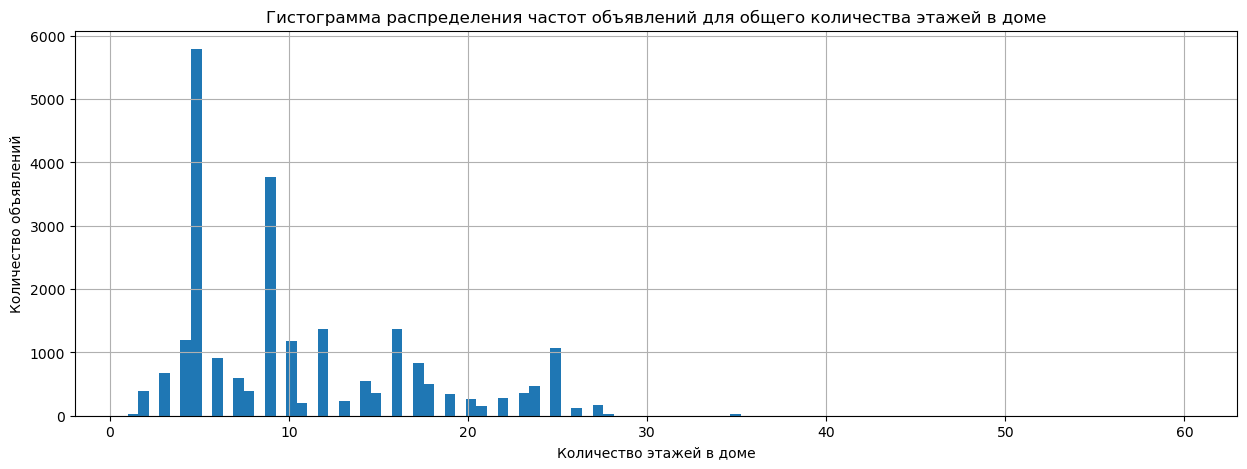

In [102]:
data['floors_total'].hist(bins=100, figsize=(15,5))
plt.xlabel('Количество этажей в доме')
plt.ylabel('Количество объявлений')
plt.title('Гистограмма распределения частот объявлений для общего количества этажей в доме')
plt.show()

На гистограмме видно, что разброс значений велик - от одноэтажных домов до небоскребов свыше 60 этажей.  
Ярко выражены два пика - пятиэтажки и девятиэтажки.

##### Построим гистограмму для расстояния до центра города в метрах, опишем наблюдения

In [103]:
#data['cityCenters_nearest'].hist(bins=100, figsize=(15,5))

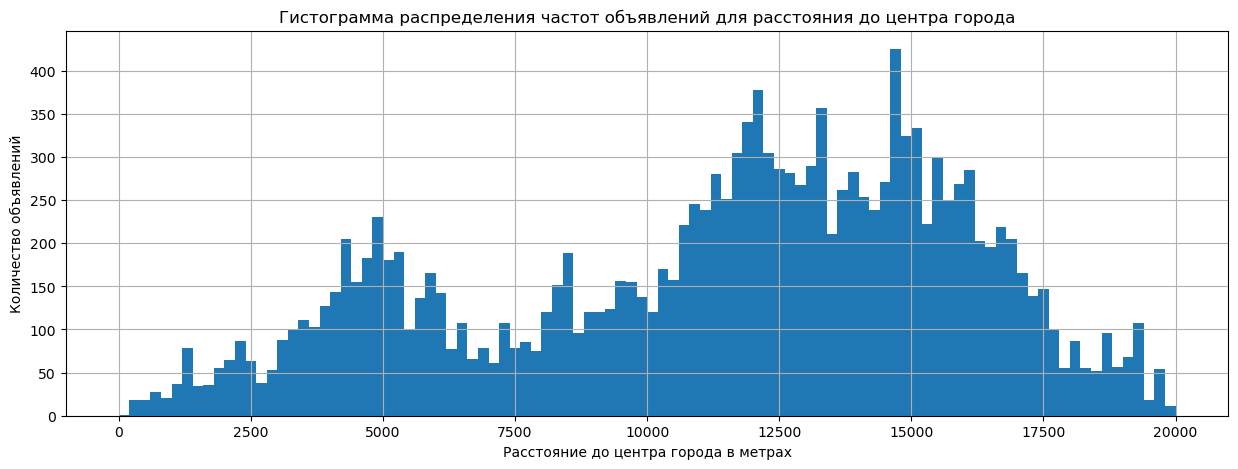

In [104]:
# Чтобы расcмотреть особенности распределения значений в интервале их наибольшего скопления, 
# построим гистограмму в другом масштабе, указав диапазон значений от 0 до 20 км

data['cityCenters_nearest'].hist(bins=100, figsize=(15,5), range=(0, 20000))
plt.xlabel('Расстояние до центра города в метрах')
plt.ylabel('Количество объявлений')
plt.title('Гистограмма распределения частот объявлений для расстояния до центра города')
plt.show()

Разброс значений велик - от квартир в самом центре до недвижимости, расположенной на удалении 80 км от города.   
В самом центре предлагается не очень много квартир.  
На гистограмме выражены три пика: 5, 12 и 15 км от центра, причем второй и третий пики (спальные районы) почти в два раза больше, чем первый. 

##### Построим гистограмму расстояния до ближайшего аэропорта, опишем наблюдения

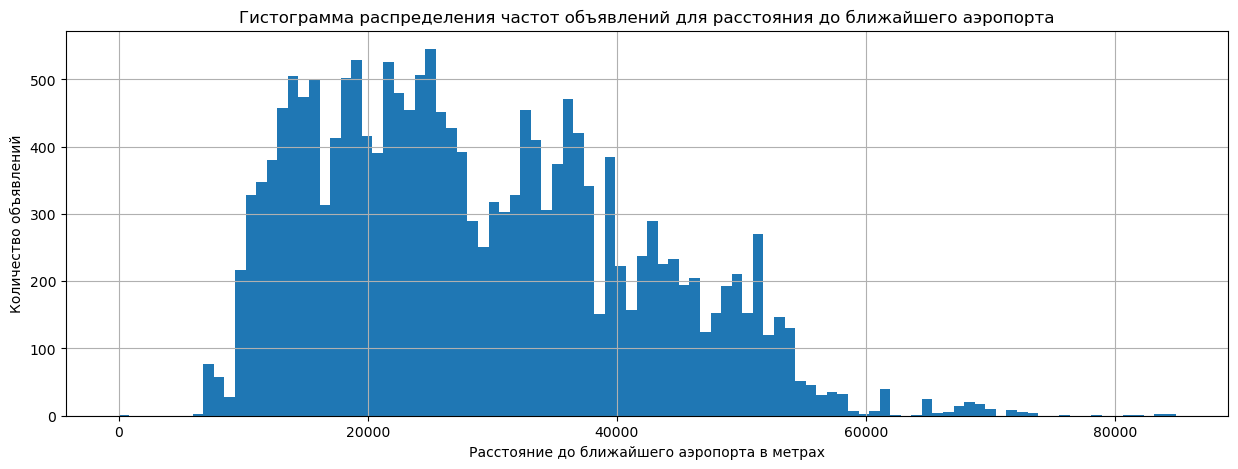

In [105]:
data['airports_nearest'].hist(bins=100, figsize=(15,5))
plt.xlabel('Расстояние до ближайшего аэропорта в метрах')
plt.ylabel('Количество объявлений')
plt.title('Гистограмма распределения частот объявлений для расстояния до ближайшего аэропорта')
plt.show()

Разброс значений велик - в непосредственной близости от аэропорта квартир очень мало, но есть недвижимость, находящаяся на расстоянии свыше 80 км от аэропорта.  
Основная масса объектов расположена в интервале от 10 до 55 км от аэропорта.

##### Построим гистограмму расстояния до ближайшего парка, опишем наблюдения

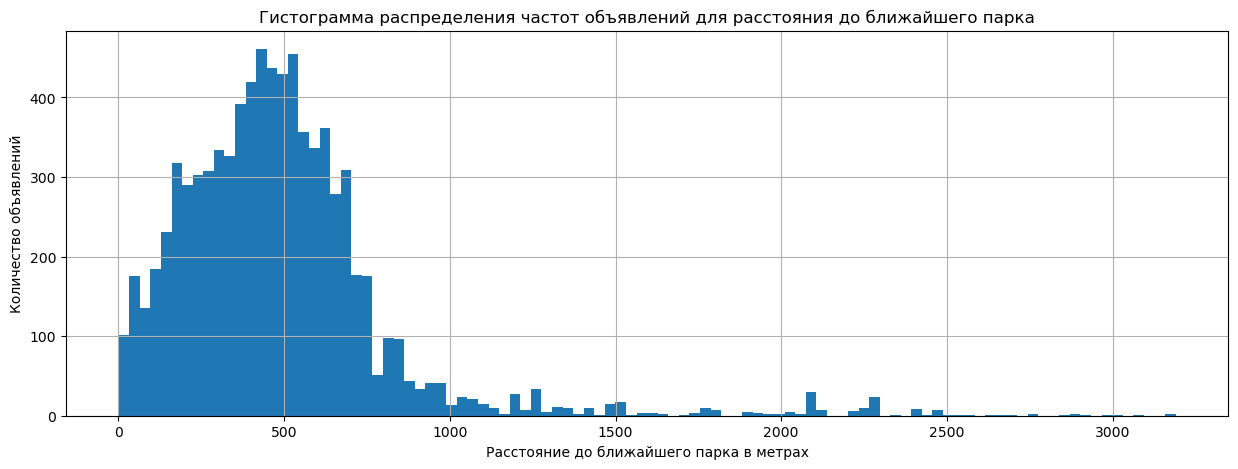

In [106]:
data['parks_nearest'].hist(bins=100, figsize=(15,5))
plt.xlabel('Расстояние до ближайшего парка в метрах')
plt.ylabel('Количество объявлений')
plt.title('Гистограмма распределения частот объявлений для расстояния до ближайшего парка')
plt.show()

Разброс значений велик - от 0 до чуть больше 3 км.  
Основная масса объектов находится на расстоянии в пределах 700 метров от парка, пик - в районе 500 метров.

##### Построим гистограмму дня публикации объявления, опишем наблюдения

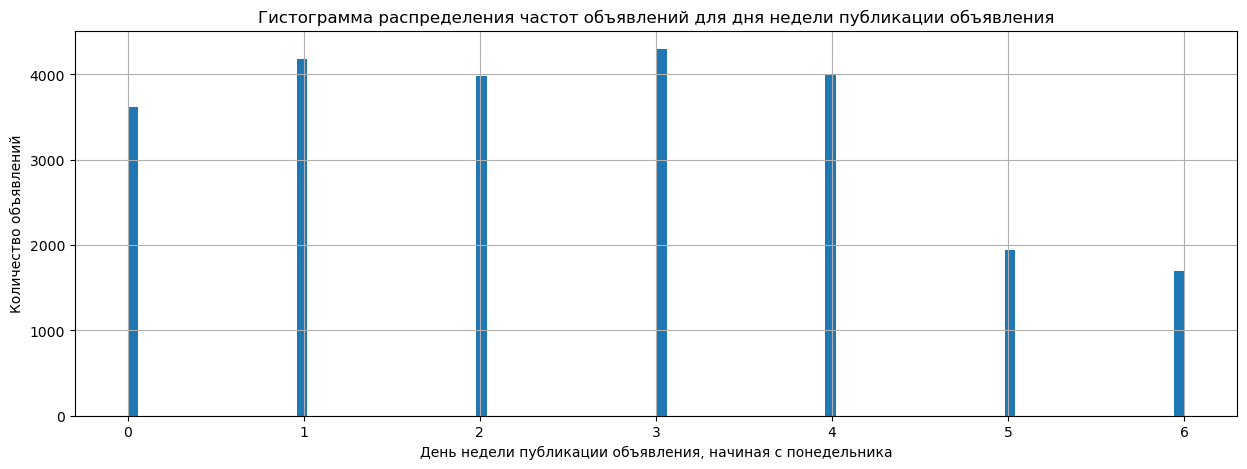

In [107]:
data['weekday_first_day_exposition'].hist(bins=100, figsize=(15,5))
plt.xlabel('День недели публикации объявления, начиная с понедельника')
plt.ylabel('Количество объявлений')
plt.title('Гистограмма распределения частот объявлений для дня недели публикации объявления')
plt.show()

Явно выражена закономерность - в выходные дни объявления публикуют в два раза реже, чем в будни.  
Чаще всего объявления публикуют в среду.

##### Построим гистограмму месяца публикации объявления, опишем наблюдения

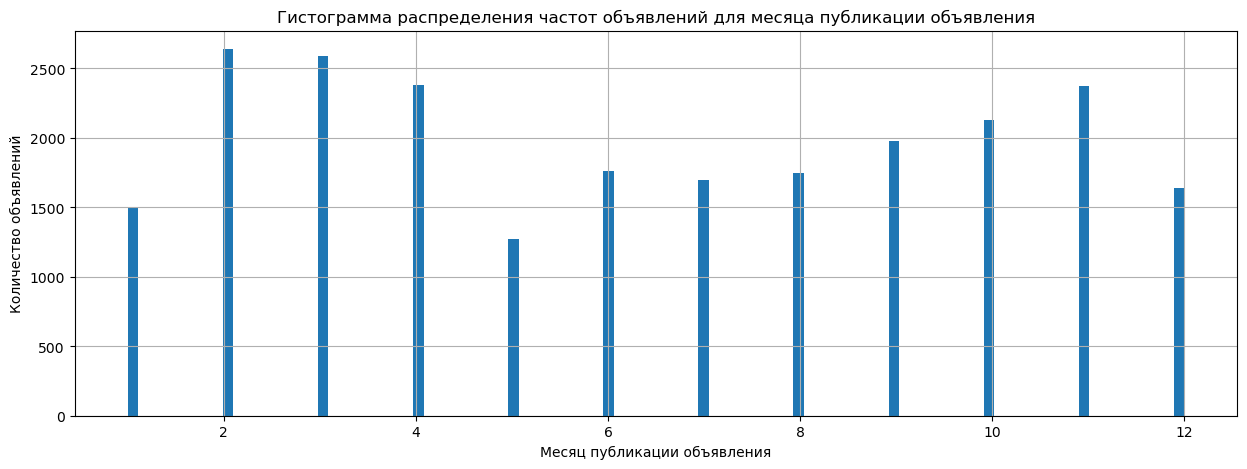

In [108]:
data['month_first_day_exposition'].hist(bins=100, figsize=(15,5))
plt.xlabel('Месяц публикации объявления')
plt.ylabel('Количество объявлений')
plt.title('Гистограмма распределения частот объявлений для месяца публикации объявления')
plt.show()

Заметно увеличение активности публикаций объявлений в холодное время года: февраль, март, апрель, сентябрь, октябрь, ноябрь.  
В теплое время года активность пуюликаций существенно снижена (видимо, это связано с дачным сезоном).  
Также заметно снижение активнности публикаций в декабре и январе (видимо, это объясняется предновогодней суетой и новогодними каникулами).

#### Изучим, как быстро продавались квартиры

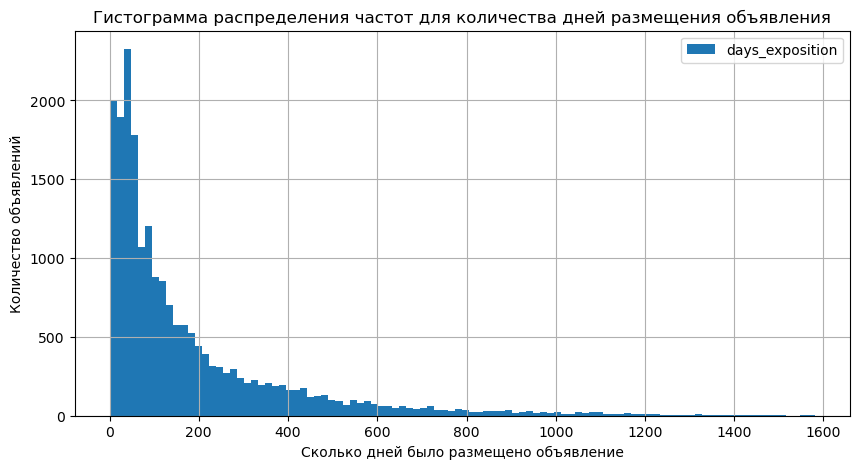

In [109]:
# Посторим гисторграмму без указания масштаба

data.plot(y = 'days_exposition', kind = 'hist', grid = True, bins=100, figsize=(10,5))
plt.xlabel('Сколько дней было размещено объявление')
plt.ylabel('Количество объявлений')
plt.title('Гистограмма распределения частот для количества дней размещения объявления')
plt.show()

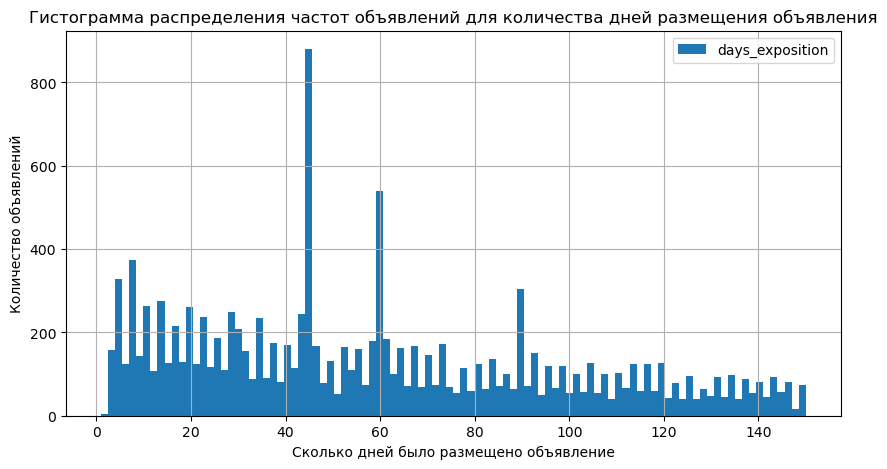

In [110]:
# Посторим гисторграмму с указанием интересующего нас диапазона (чтобы рассмотреть подробнее)
data.plot(y = 'days_exposition', kind = 'hist', grid = True, bins=100, figsize=(10,5), range = (1,150))
plt.xlabel('Сколько дней было размещено объявление')
plt.ylabel('Количество объявлений')
plt.title('Гистограмма распределения частот объявлений для количества дней размещения объявления')
plt.show()

In [111]:
data['days_exposition'].agg(['count', 'min', 'max', 'mean', 'median'])

count    20,518.00
min           1.00
max       1,580.00
mean        180.89
median       95.00
Name: days_exposition, dtype: float64

Минимум имеет подозрительное значение - всего 1 день. Вряд ли квартиры так быстро продаются.

In [112]:
# Посмотрим на срез с длительностью продажи меньше недели 

data_week_exposition = data.query('days_exposition < 7')

# Выведем количество квартир, которые были проданы в течение недели
data_week_exposition['days_exposition'].count()

614

Размах длительности продаж квартиры очень велик от 1 дня до 4,5 лет.  
614 квартир было продано очень быстро - в течение недели с даты публикации объявления.  
Однако были и такие объявления, которые "висели" больше четырех лет (1580 дней).  
В среднем квартиры продавались в промежутке от 3-х до 6-ти месяцев.  

При увеличении масштаба на гистограмме стали заметны ярко выраженные пики массового снятия объявлений на 45, 60 и 90 день.  
Логично предположить, что на 45, 60 и 90 день объявления принудительно удаляются с ресура как объявления, утратившие свою актуальность.    
Если квартира еще не продана, то по истечение установленного регламентом срока, у публикатора объявления всегда  есть возможность его пролонгировать. 

#### Изучим, какие факторы больше всего влияют на общую (полную) стоимость объекта недвижимости.


##### Зависимость цены от общей площади 

In [113]:
# Создадим сводную таблицу

pivot_price_total_area = data.pivot_table(index='last_price', values='total_area', aggfunc='mean').reset_index()
#pivot_price_total_area.head()

In [114]:
# Для визуализации взаимосвязи между двумя численными величинами наиболее подходит диаграмма рассеивания
#pivot_price_total_area.plot(kind='scatter', x='last_price', y='total_area', alpha=0.3, figsize=(10,5))

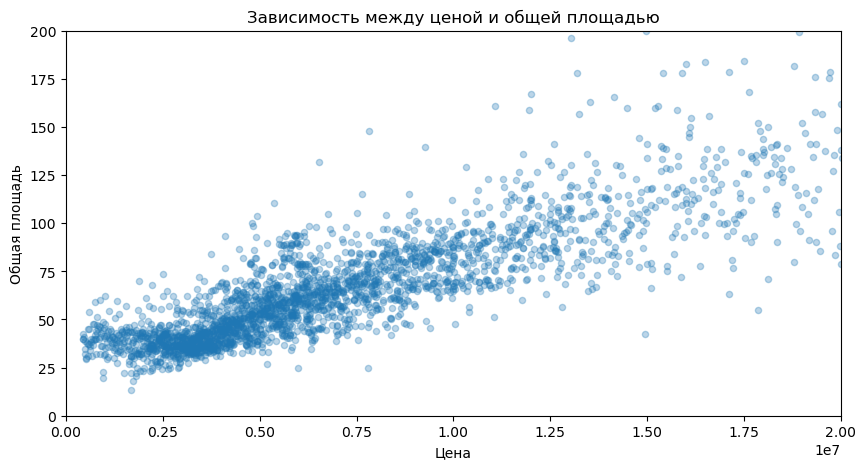

In [115]:
# Зададим интересующий нас диапазон значений для ближайшего рассмотрения 
ax = pivot_price_total_area.plot(kind='scatter', x='last_price', y='total_area', alpha=0.3, figsize=(10,5))
plt.xlabel('Цена')
plt.ylabel('Общая площадь')
plt.title('Зависимость между ценой и общей площадью')
ax.set_xlim(0, 20000000)
ax.set_ylim(0, 200)
plt.show()

In [116]:
# Рассчитаем коэффициент корреляции
corr_total_area = data['last_price'].corr(data['total_area']).round(2)
corr_total_area

0.65

По графику прослеживается наличие небольшой линейной зависимости -   
с увеличением общей площади квартиры вероятность увеличения её цены тоже увеличивается.  
В числовом виде эту зависимость можно выразить через коэффициент корреляции.  
Коэффициент корреляции между ценой квартиры и размером общей площади равен 0.65


##### Зависимость цены от жилой площади 

In [117]:
# Создадим сводную таблицу
pivot_price_living_area = data.pivot_table(index='last_price', values='living_area', aggfunc='mean').reset_index()
#pivot_price_living_area.head()

In [118]:
# Для визуализации взаимосвязи между двумя численными величинами наиболее подходит диаграмма рассеивания
# pivot_price_living_area.plot(kind='scatter', x='last_price', y='living_area', alpha=0.3, figsize=(10,5))

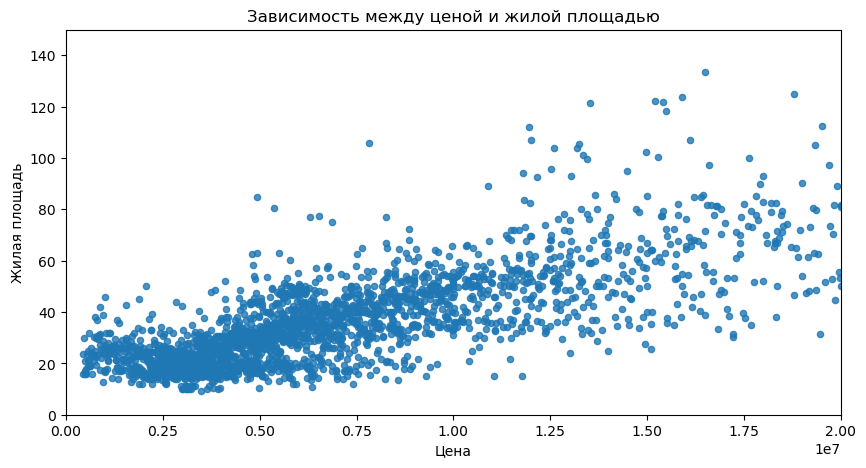

In [145]:
# Зададим интересующий нас диапазон значений для ближайшего рассмотрения 
ax = pivot_price_living_area.plot(kind='scatter', x='last_price', y='living_area', alpha=0.8, figsize=(10,5))
plt.xlabel('Цена')
plt.ylabel('Жилая площадь')
plt.title('Зависимость между ценой и жилой площадью')
ax.set_xlim(0, 20000000)
ax.set_ylim(0, 150)
plt.show()

In [120]:
# Рассчитаем коэффициент корреляции
corr_living_area = data['last_price'].corr(data['living_area']).round(2)
corr_living_area

0.57

По графику прослеживается наличие небольшой линейной зависимости -   
с увеличением жилой площади квартиры вероятность увеличения её цены тоже увеличивается.  
В числовом виде эту зависимость можно выразить через коэффициент корреляции.    
Коэффициент корреляции между ценой квартиры и размером её жилой площади равен 0.57

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Небольшую зависимость от жилой площади мы наблюдаем и тут. 

##### Зависимость цены от площади кухни

In [121]:
# Создадим сводную таблицу
pivot_price_kitchen_area = data.pivot_table(index='last_price', values='kitchen_area', aggfunc='mean').reset_index()
# pivot_price_kitchen_area.head()

In [122]:
# Для визуализации взаимосвязи между двумя численными величинами наиболее подходит диаграмма рассеивания
# pivot_price_kitchen_area.plot(kind='scatter', x='last_price', y='kitchen_area', alpha=0.3, figsize=(10,5))

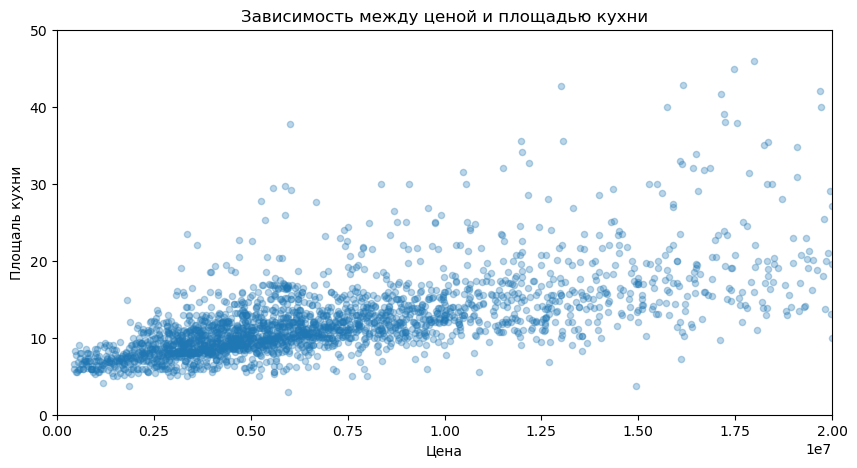

In [123]:
# Зададим интересующий нас диапазон значений для ближайшего рассмотрения 
ax = pivot_price_kitchen_area.plot(kind='scatter', x='last_price', y='kitchen_area', alpha=0.3, figsize=(10,5))
plt.xlabel('Цена')
plt.ylabel('Площаль кухни')
plt.title('Зависимость между ценой и площадью кухни')
ax.set_xlim(0, 20000000)
ax.set_ylim(0, 50)
plt.show()

In [124]:
# Рассчитаем коэффициент корреляции
corr_kitchen_area = data['last_price'].corr(data['kitchen_area']).round(2)
corr_kitchen_area

0.52

По графику прослеживается наличие небольшой линейной зависимости -   
с увеличением площади кухни вероятность увеличения её цены тоже увеличивается.  
В числовом виде эту зависимость можно выразить через коэффициент корреляции.    
Коэффициент корреляции между ценой квартиры и размером площади её кухни - 0.52

##### Зависимость цены от количества комнат

In [125]:
# Создадим сводную таблицу
pivot_price_rooms = data.pivot_table(index='last_price', values='rooms', aggfunc='mean').reset_index()
# pivot_price_rooms.head()

In [126]:
# Для визуализации взаимосвязи между двумя численными величинами наиболее подходит диаграмма рассеивания
# pivot_price_rooms.plot(kind='scatter', x='last_price', y='rooms', alpha=0.3, figsize=(10,5))

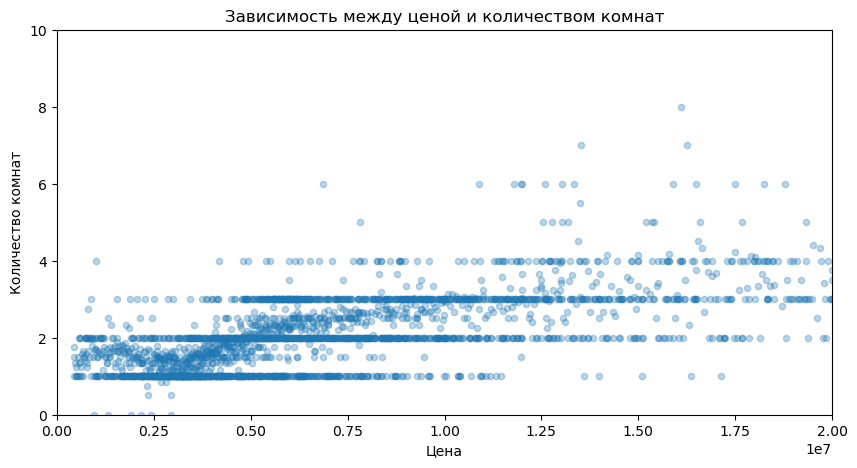

In [127]:
# Зададим интересующий нас диапазон значений для ближайшего рассмотрения 
ax = pivot_price_rooms.plot(kind='scatter', x='last_price', y='rooms', alpha=0.3, figsize=(10,5))
plt.xlabel('Цена')
plt.ylabel('Количество комнат')
plt.title('Зависимость между ценой и количеством комнат')
ax.set_xlim(0, 20000000)
ax.set_ylim(0, 10)
plt.show()

In [128]:
# Рассчитаем коэффициент корреляции
corr_rooms = data['last_price'].corr(data['rooms']).round(2)
corr_rooms

0.36

На диаграмме разброса чётко прослеживается несколько горизонтальных линий для квартир с одинаковым количеством комнат:   
однокомнатные, двухкомнатные, трехкомнатные и т.д.
Это свидетельствует о том, что существует определенный ценовой коридор для каждого типа квартир.   
На диаграмме также заметно, что однокомнатные квартиры имеют более низкую стоимость по сравнению с двухкомнатными,   
а трехкомнатные квартиры - более высокую стоимость по сравнению с двухкомнатными и т.д.   
В числовом виде эту зависимость можно выразить через коэффициент корреляции.  
Коэффициент корреляции между ценой квартиры и количеством комнат - 0.36


<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
С выводами согласен 

##### Зависимость цены от этажа, на котором расположена квартира

In [129]:
# Группируем данные по категориям этажей, для каждой категории вычисляем среднее значение стоимости квартир
grouped_data = data.groupby('floor_category')['last_price'].mean()
grouped_data

floor_category
другой      6,675,444.24
первый      4,803,560.23
последний   7,364,675.27
Name: last_price, dtype: float64

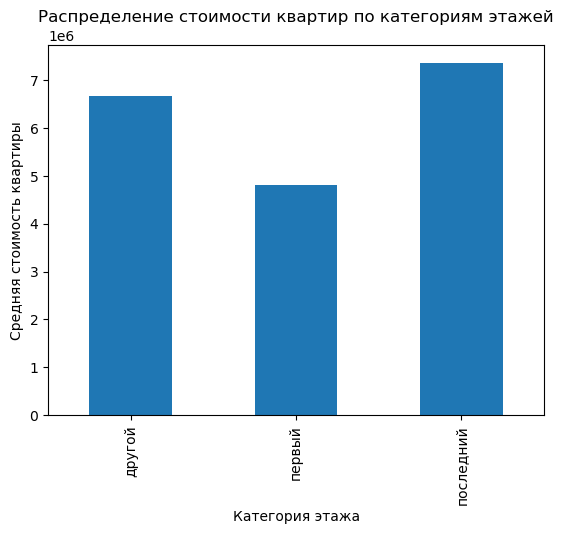

In [130]:
# Для визуализации взаимосвязи между этими параметрами наиболее подходит столбчатая диаграмма
grouped_data.plot(kind='bar')
plt.title('Распределение стоимости квартир по категориям этажей')
plt.xlabel('Категория этажа')
plt.ylabel('Средняя стоимость квартиры')
plt.show()

In [131]:
# Создаем сводную таблицу
grouped_data_floor = data.pivot_table(index='floor_category', values='last_price', aggfunc=['count', 'mean'])
grouped_data_floor


,count,mean
,last_price,last_price
floor_category,,
другой,17446,"6,675,444.24"
первый,2917,"4,803,560.23"
последний,3336,"7,364,675.27"


In [132]:
# Добавляем столбец, в котром отражен результат отношения средней цены каждой категории  
# к средней цене квартир на первых этажах, которая имееет минимальное значение среди всех трёх категорий

grouped_data_floor['compare_to_min'] = grouped_data_floor['mean'] / grouped_data_floor['mean'].min()
grouped_data_floor

,count,mean,compare_to_min
,last_price,last_price,
floor_category,,,
другой,17446,"6,675,444.24",1.39
первый,2917,"4,803,560.23",1.00
последний,3336,"7,364,675.27",1.53


Самая низкая средняя стоимость квартир относится к категории недвижимости на первых этажах - 4,8 млн. рублей.  
Квартиры, относящихся к категории "другой этаж" и "последний этаж" стоят на 39% и 53% дороже соответственно. 


##### Зависимость цены от дня недели публикации объявления

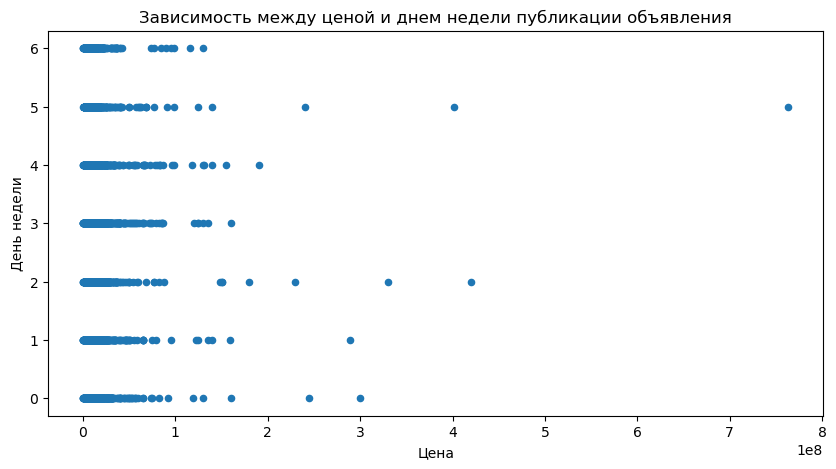

In [133]:
# Для визуализации взаимосвязи построим диаграмму рассеивания

data.plot(kind='scatter', x='last_price', y='weekday_first_day_exposition', figsize=(10,5))
plt.xlabel('Цена')
plt.ylabel('День недели')
plt.title('Зависимость между ценой и днем недели публикации объявления')
plt.show()


На диаграмме чётко прослеживается семь горизонтальных линий, соответствующих каждому дню недели.   
Вид диаграммы свидетельствует об отсутствии какой-либо зависимости между ценой квартиры и днем недели публикации объявления.

##### Зависимость цены от месяца публикации объявления

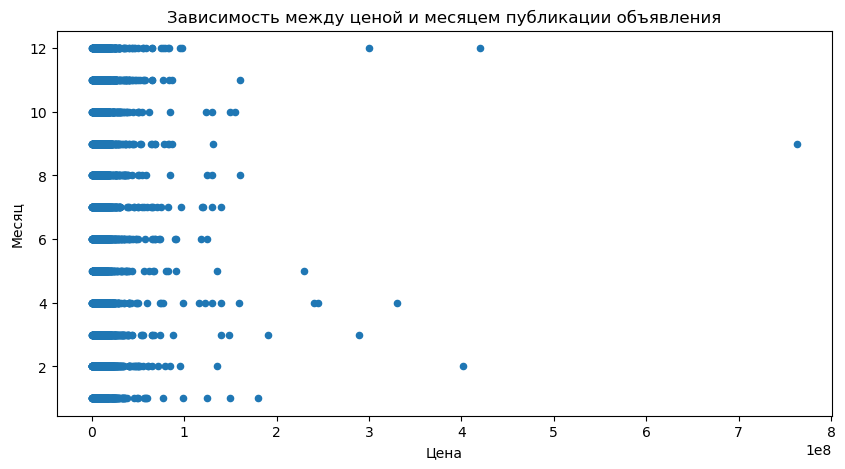

In [134]:
# Для визуализации взаимосвязи построим диаграмму рассеивания

data.plot(kind='scatter', x='last_price', y='month_first_day_exposition', figsize=(10,5))
plt.xlabel('Цена')
plt.ylabel('Месяц')
plt.title('Зависимость между ценой и месяцем публикации объявления')
plt.show()


На диаграмме чётко прослеживается 12 горизонтальных линий, соответствующих каждому месяцу.    
Вид диаграммы свидетельствует об отсутствии какой-либо зависимости между ценой квартиры и месяцем публикации объявления.


##### Зависимость цены от года публикации объявления

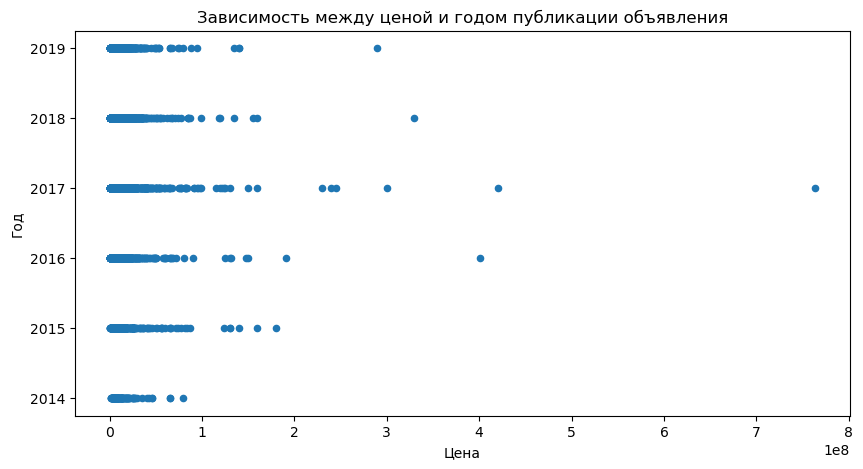

In [135]:
# Для визуализации взаимосвязи построим диаграмму рассеивания

data.plot(kind='scatter', x='last_price', y='year_first_day_exposition', figsize=(10,5))
plt.xlabel('Цена')
plt.ylabel('Год')
plt.title('Зависимость между ценой и годом публикации объявления')
plt.show()

На диаграмме чётко прослеживаются 6 горизонтальных линий, соответствующих каждому году - с 2014 по 2019.   
Вид диаграммы свидетельствуют об отсутствии какой-либо зависимости между ценой квартиры и годом публикации объявления.

Изучив зависимость стоимости квартиры от различных параметров, можно сделать вывод,   
что из всех изученных параметров наибольшее влияние на цену оказывает размер общей и жилой площади.

#### Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.  Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра. 

In [136]:
# Создадим сводную таблицу, 
# содержащую сведения о количестве объявлений и средней цены одного кв. метра к каждом населенном пункте

data_pivot_locatity_name = data.pivot_table(index='locality_name', \
                                             values='price_per_meter', aggfunc={'price_per_meter':['count', 'mean']})
data_pivot_locatity_name

,count,mean
locality_name,,
адрес не указан,49,"94,310.02"
бокситогорск,16,"17,551.62"
волосово,36,"40,183.31"
волхов,111,"35,087.70"
всеволожск,398,"68,654.47"
...,...,...
сосновый бор,87,"75,220.40"
сясьстрой,24,"34,405.46"
тихвин,49,"40,048.55"


In [137]:
# Отсортируем сводную таблицу по убыванию количества объявлений
data_pivot_locatity_name  = data_pivot_locatity_name.sort_values(by='count', ascending=False)
data_pivot_locatity_name

,count,mean
locality_name,,
санкт-петербург,15721,"114,856.11"
поселок мурино,556,"85,681.76"
поселок шушары,440,"78,677.38"
всеволожск,398,"68,654.47"
пушкин,369,"103,125.82"
...,...,...
поселок почап,1,"16,038.00"
деревня хязельки,1,"47,826.00"
деревня чудской бор,1,"16,287.00"


In [149]:
# Выведем 10 населённых пунктов с наибольшим числом объявлений
data_pivot_locatity_name = data_pivot_locatity_name
data_pivot_locatity_name = data_pivot_locatity_name.head(10)

,count,mean
locality_name,,
санкт-петербург,15721,"114,856.11"
поселок мурино,556,"85,681.76"
поселок шушары,440,"78,677.38"
всеволожск,398,"68,654.47"
пушкин,369,"103,125.82"
колпино,338,"75,424.57"
поселок парголово,327,"90,175.89"
гатчина,307,"68,746.11"
деревня кудрово,299,"92,473.59"


In [147]:
# В полученной сводной таблице найдем населенный пункт с самой низкой ценой за один кв. метр
min_price = data_pivot_locatity_name['mean'].min()
data_pivot_locatity_name.query('mean == @min_price')

,count,mean
locality_name,,
деревня старополье,3,"11,206.33"


In [140]:
# В полученной сводной таблице найдем населенный пункт с самой высокой ценой за один кв. метр
max_price = data_pivot_locatity_name['mean'].max()
data_pivot_locatity_name.query('mean == @max_price')

,count,mean
locality_name,,
зеленогорск,24,"115,122.75"


In [141]:
# Найдем во всем датасете населенный пункт с самой низкой ценой за один кв. метр
min_price = data['price_per_meter'].min()
data_min_price = data.loc[data['price_per_meter'] == min_price]

data_min_price[['locality_name', 'price_per_meter']]

,locality_name,price_per_meter
14911,поселок станции свирь,"7,963.00"


In [142]:
# Найдем во всем датасете населенный пункт с самой высокой ценой за один кв. метр
max_price = data['price_per_meter'].max()
data_max_price = data.loc[data['price_per_meter'] == max_price]

data_max_price[['locality_name', 'price_per_meter']]

,locality_name,price_per_meter
12971,санкт-петербург,"1,907,500.00"


- **Самое большое количество квартир продается в г. Санкт-Петербург - 15721 объявлений.**  
Следующим после Санкт-Петербурга по числу размещаемых объявлений идет населеннымй пункт Мурино - 556 объявлений.  
Таким образом, по количеству объявлений Санкт-Петербург лидирует с отрывом от Мурино почти в 30 раз!  

- **В выборке из 10 населенных пунктов с самым большим числом объявлений:**  
  - минимальная цена за один кв. метр - 58,1 тыс. руб. в населенном пункте Выборг

  - максимальная цена за один кв. метр - 114,8 тыс. руб.  в городе Санкт-Петербург  
- **Во всем датасете:**   
  - минимальная цена за один кв. метр - 7963 руб. в поселке станции Свирь

  - максимальная цена за один кв. метр - 1907500 руб. в городе Санкт-Петербург 

#### Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

In [143]:
# Создадим сводную таблицу для среза квартир, расположенных в пределах г.Санкт-Петербург
data_pivot_St_Peter_km = data.query('locality_name == "санкт-петербург"')\
.pivot_table(index='center_distance', values='last_price', aggfunc='mean')
data_pivot_St_Peter_km.head()

,last_price
center_distance,
0.00,"31,449,115.85"
1.00,"21,206,720.83"
2.00,"17,788,319.61"
3.00,"11,126,581.00"
4.00,"13,304,279.53"


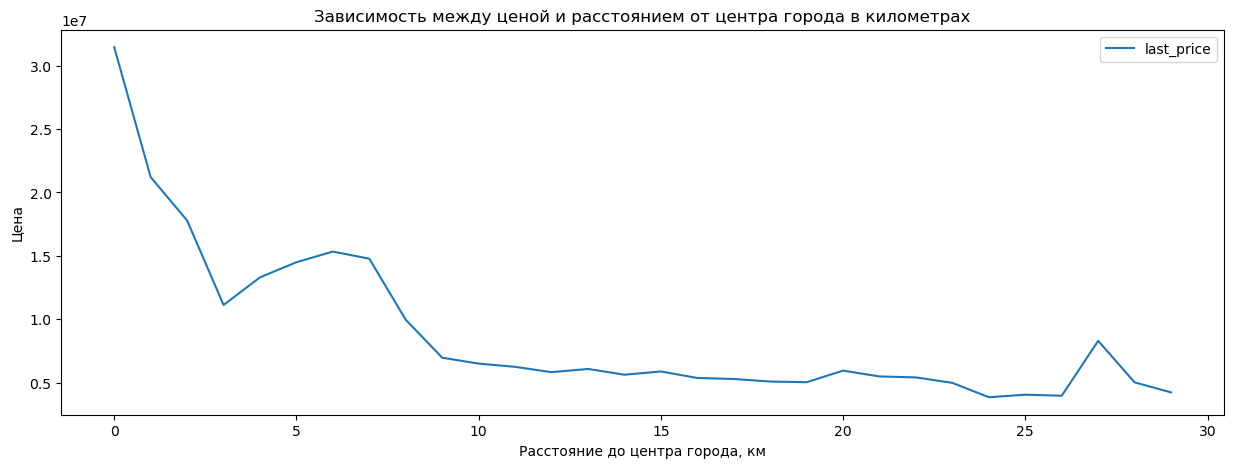

In [144]:
# Построим график зависимости цены от расстояния до центра города

data_pivot_St_Peter_km.plot(figsize=(15,5))
plt.ylabel('Цена')
plt.xlabel('Расстояние до центра города, км')
plt.title('Зависимость между ценой и расстоянием от центра города в километрах')
plt.show()

По графику прослеживается обратная зависимость между ценой квартиры и её удаленностью от центра города -    
с увеличениием расстояния от центра цены на квартиры снижаются.  
Самые дорогие квартиры находятся в радиусе 3 км, на расстоянии 5-7 км заметен небольшой всплеск стоимости, далее по мере удаления от центра цены идут на спад.

### Общий вывод

**В результате исследования рынка недвижимости Санкт-Петербурга и его окресностей за период с ноября 2014 по май 2019 г.,   
были выявлены следующие особенности и зависимости:**  

- Большинство объектов недвижимости имеет общую площадь до 100 кв.м, при этом пик приходится на 40 кв.м;
- Большинство объектов недвижимости имеет жилую площадь до 60 кв.м, при этом пик приходится на 17-18 кв.м;
- Большинство объектов недвижимости имеет площадь кухни до 15 кв.м, при этом пик приходится на 6-10 кв.м;
- Цена большинства объектов недвижимости находится в интервале до 10 млн. рублей, при этом самая распростаненная цена квартиры лежит в интервале от 3 до 4,5 млн. руб.;
- В подавляющем большинстве предлагаются одно- и двух- комнатные квартиры (их примерно поровну), трехкомнатных квартир предлагается на 30% меньше, объектов недвижимости с числом комнат больше трех очень мало;
- В подавляющем большинстве высота потолков лежит в интервале от 2,5 до 3,0 метров, самая распространенная высота потолков 2,7 метра;
- Много продающихся квартир расположено ниже 10 этажа, причем большинство из них расположены с 1 по 5 этаж. Мало предложений на очень высоких этажах;
- Квартир, расположенных не на крайних этажах предлагается гораздо больше, чем на первом и последнем этажах (приблизительно в 6 раз больше). При этом, количество предложений квартир на первом и последнем этаже примерно одинаково;
- Большинство квартир продается в пяти- или девяти- этажных домах;
- Большинство квартир расположено на расстоянии 5, 12 и 15 км от центра, при этом в спальных районах (12 и 15 км) предложений почти в два раза больше;
- Основная масса объектов расположена в интервале от 10 до 55 км от аэропорта;
- Основная масса объектов находится на расстоянии 500 метров от парка;
- Обнаружена зависимость - в выходные дни объявления публикуют в два раза реже, чем в будни. Чаще всего объявления публикуют со среды по пятницу;
- Обнаружена зависимость - увеличение активности публикаций объявлений в холодное время года (за исключением, декабря и января) и снижение активности в теплый "дачный" сезон;
- Размах длительности продажи квартиры очень велик: некоторые квартиры продавались очень быстро - в течение недели с даты публикации объявления, а некоторые "висели" больше четырех лет. В среднем квартиры продавались в интервале от 3-х до 6-ти месяцев.
- С увеличением общей площади, жилой площади, а также площади кухни стоимость квартиры увеличивается;
- С увеличением числа комнат стоимость квартиры увеличивается (обычно число комнат находится в прямой зависимости от общей площади квартиры);
- Квартиры, расположенные на первом этаже, стоят на 40-50% дешевле, чем квартиры на других этажах, в т.ч. на последнем;
- Между ценой квартиры и днем недели, в который было опубликовано объявление, нет никакой взаимосвязи;
- Между ценой квартиры и месяцем, в который было опубликовано объявление, нет никакой взаимосвязи;
- Самое большое количество квартир продается в Санкт-Петербурге - 15721 объявлений.  
- Минимальная цена за один кв. метр - 7963 руб. (поселок станции Свирь)
- Максимальная цена за один кв. метр - 1907500 руб. (город Санкт-Петербург), но похоже, что товарищ всё-таки ошибся с нулями
- Самые дорогие квартиры находятся в радиусе 3 км, на расстоянии 5-7 км заметен небольшой всплеск стоимости, далее по мере удаления от центра цены идут на спад.

